# LSTM Models with Multiple Embeddings - Combined Notebook
## Drug Reviews Classification - Gershom

**This notebook combines all three LSTM experiments:**
1. Word2Vec Skip-gram Embeddings
2. GloVe Embeddings
3. TF-IDF Features with Dense/LSTM

**Task**: Drug review rating prediction (binary classification: rating >= 6)

---

### Notebook Structure:
1. **Shared Setup**: Imports, Data Loading, EDA
2. **Experiment 1**: LSTM + Word2Vec
3. **Experiment 2**: LSTM + GloVe
4. **Experiment 3**: Dense/LSTM + TF-IDF
5. **Results Comparison**: Compare all three models

## Part 1: Shared Setup and Data Loading

### 1.1 Mount Google Drive (if using Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings

Mounted at /content/drive
/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings


### 1.2 Install Dependencies

In [ ]:
# Install gensim for Word2Vec
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.9 MB/s eta 0:00:00


### 1.3 Import Libraries

In [ ]:
# Standard libraries
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, mean_squared_error,
    mean_absolute_error, r2_score
)

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dense, Dropout, Embedding,
    Input, GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Shared modules
from src.data_utils import DataLoader, create_dataset_from_dataframe
from src.preprocessing_pipeline import get_preprocessor, TextPreprocessor
from embeddings.word2vec_embedding import Word2VecEmbedding, get_word2vec_embedding
from embeddings.glove_embedding import GloVeEmbedding, get_glove_embedding
from embeddings.tfidf_embedding import TfidfEmbedding, get_tfidf_embedding

print("All imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

All imports successful!
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1.4 Configuration

In [ ]:
# Paths
TRAIN_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_train.csv'
VAL_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_validation.csv'
TEST_PATH = '/content/drive/MyDrive/Drug-Reviews-NLP-With-Multiple-Embeddings/data/drug_review_test.csv'

# Data columns
TEXT_COLUMN = 'review'
LABEL_COLUMN = 'rating'

# Classification setup
CLASSIFICATION_TYPE = 'binary'  # 'binary', 'multiclass', or 'regression'
THRESHOLD = 6  # For binary classification: >= 6 = positive

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Configuration set!")
print(f"Classification type: {CLASSIFICATION_TYPE}")
print(f"Threshold: {THRESHOLD}")

Configuration set!
Classification type: binary
Threshold: 6


### 1.5 Load Data

In [ ]:
# Load datasets
print("Loading datasets...")
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Train size: {len(train_df):,}")
print(f"Validation size: {len(val_df):,}")
print(f"Test size: {len(test_df):,}")
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nRating distribution (train):")
print(train_df[LABEL_COLUMN].value_counts().sort_index())

Loading datasets...
Train size: 110,811
Validation size: 27,703
Test size: 46,108

Columns: ['Unnamed: 0', 'patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length']

Rating distribution (train):
rating
1.0     14286
2.0      4776
3.0      4540
4.0      3501
5.0      5711
6.0      4359
7.0      6671
8.0     13305
9.0     19407
10.0    34255
Name: count, dtype: int64


### 1.6 Exploratory Data Analysis (EDA)

Comprehensive dataset exploration with visualizations.

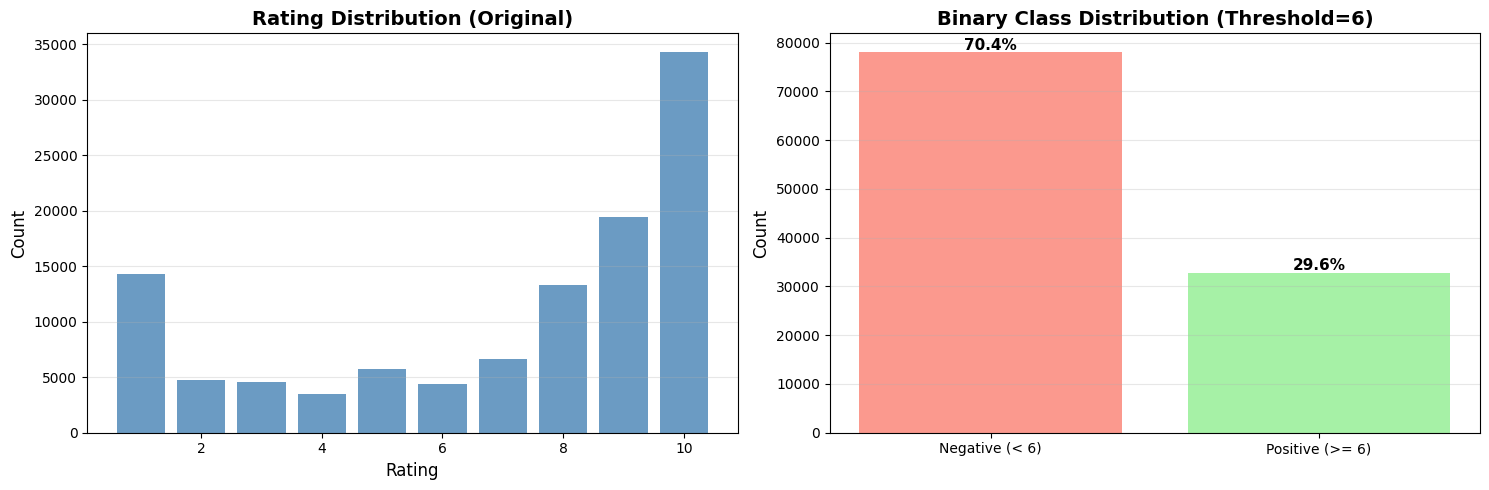

Total samples: 110,811
Negative class (< 6): 32,814 (29.61%)
Positive class (>= 6): 77,997 (70.39%)


In [ ]:
# 1. Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Raw rating distribution
rating_counts = train_df[LABEL_COLUMN].value_counts().sort_index()
axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Rating Distribution (Original)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Binary classification distribution
binary_labels = (train_df[LABEL_COLUMN] >= THRESHOLD).astype(int)
binary_counts = binary_labels.value_counts()
axes[1].bar(['Negative (< 6)', 'Positive (>= 6)'], binary_counts.values,
            color=['salmon', 'lightgreen'], alpha=0.8)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Binary Class Distribution (Threshold=6)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for i, v in enumerate(binary_counts.values):
    axes[1].text(i, v + 500, f'{v/len(train_df)*100:.1f}%',
                ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total samples: {len(train_df):,}")
print(f"Negative class (< 6): {binary_counts[0]:,} ({binary_counts[0]/len(train_df)*100:.2f}%)")
print(f"Positive class (>= 6): {binary_counts[1]:,} ({binary_counts[1]/len(train_df)*100:.2f}%)")

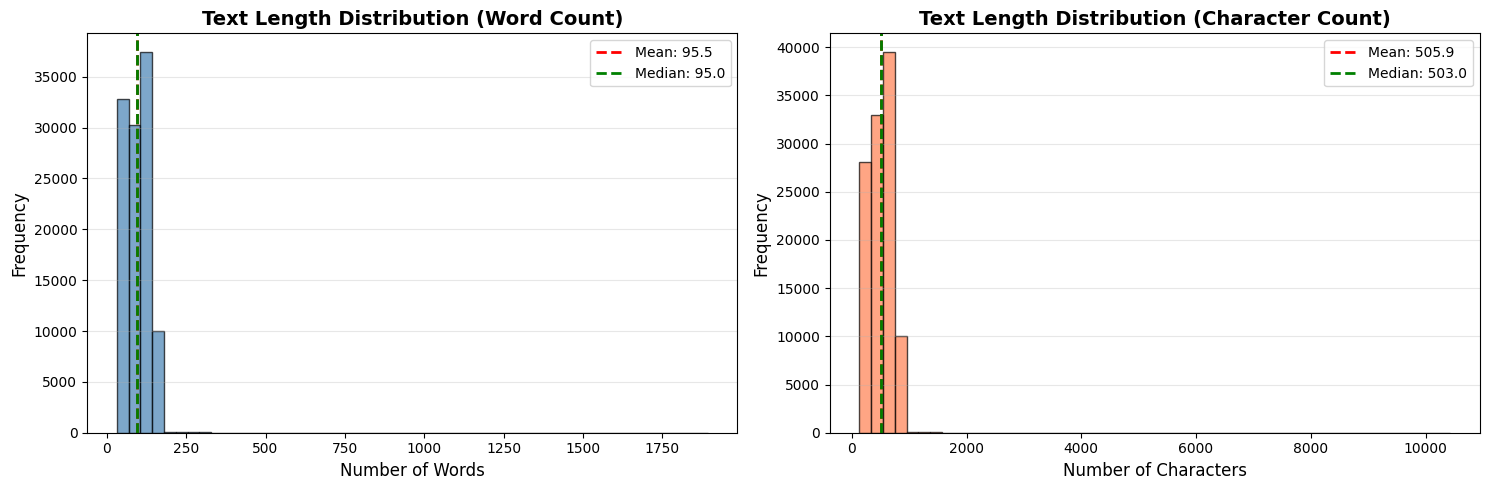

Text Length Statistics:
count    110811.000000
mean         95.475458
std          38.784704
min          31.000000
25%          63.000000
50%          95.000000
75%         130.000000
max        1894.000000
Name: text_length, dtype: float64

90th percentile: 142 words
95th percentile: 147 words
99th percentile: 155 words


In [ ]:
# 2. Text Length Distribution
train_df['text_length'] = train_df[TEXT_COLUMN].fillna('').apply(lambda x: len(x.split()))
train_df['char_length'] = train_df[TEXT_COLUMN].fillna('').apply(len)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Word count distribution
axes[0].hist(train_df['text_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(train_df['text_length'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {train_df["text_length"].mean():.1f}')
axes[0].axvline(train_df['text_length'].median(), color='green', linestyle='--',
                linewidth=2, label=f'Median: {train_df["text_length"].median():.1f}')
axes[0].set_xlabel('Number of Words', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Text Length Distribution (Word Count)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Character count distribution
axes[1].hist(train_df['char_length'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(train_df['char_length'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {train_df["char_length"].mean():.1f}')
axes[1].axvline(train_df['char_length'].median(), color='green', linestyle='--',
                linewidth=2, label=f'Median: {train_df["char_length"].median():.1f}')
axes[1].set_xlabel('Number of Characters', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Text Length Distribution (Character Count)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Text Length Statistics:")
print(train_df['text_length'].describe())
print(f"\n90th percentile: {train_df['text_length'].quantile(0.9):.0f} words")
print(f"95th percentile: {train_df['text_length'].quantile(0.95):.0f} words")
print(f"99th percentile: {train_df['text_length'].quantile(0.99):.0f} words")

Total words (with repetition): 10,510,349
Unique words (vocabulary size): 41,922
Average word frequency: 250.71

Words needed for 80% coverage: 445
Words needed for 90% coverage: 1,244


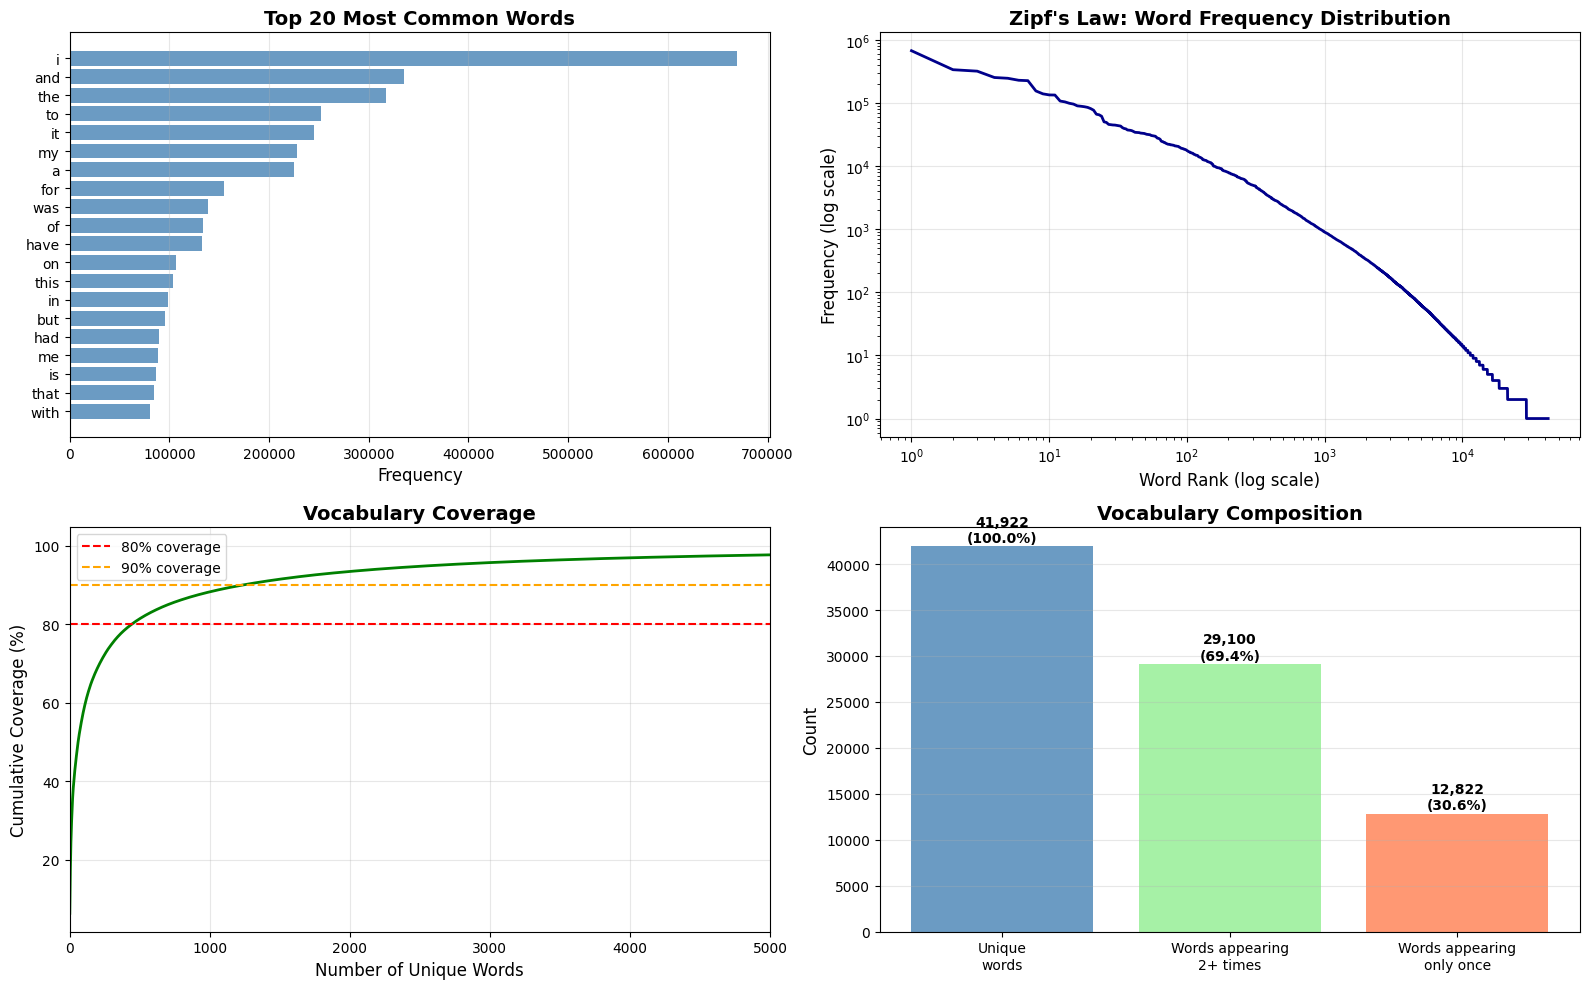


Rare words (appearing only once): 12,822 (30.59%)


In [ ]:
# 3. Vocabulary Analysis
all_words = []
for text in train_df[TEXT_COLUMN].fillna(''):
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    all_words.extend(words)

word_freq = Counter(all_words)
most_common = word_freq.most_common(30)

print(f"Total words (with repetition): {len(all_words):,}")
print(f"Unique words (vocabulary size): {len(word_freq):,}")
print(f"Average word frequency: {len(all_words)/len(word_freq):.2f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 20 most common words
words, counts = zip(*most_common[:20])
axes[0, 0].barh(range(len(words)), counts, color='steelblue', alpha=0.8)
axes[0, 0].set_yticks(range(len(words)))
axes[0, 0].set_yticklabels(words)
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Frequency', fontsize=12)
axes[0, 0].set_title('Top 20 Most Common Words', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='x')

# Word frequency distribution (Zipf's Law)
frequencies = sorted(word_freq.values(), reverse=True)
axes[0, 1].plot(range(1, len(frequencies) + 1), frequencies, color='darkblue', linewidth=2)
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlabel('Word Rank (log scale)', fontsize=12)
axes[0, 1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[0, 1].set_title("Zipf's Law: Word Frequency Distribution", fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Vocabulary coverage
cumsum = np.cumsum([count for _, count in word_freq.most_common()])
total_words = sum(word_freq.values())
coverage_pct = (cumsum / total_words) * 100

axes[1, 0].plot(range(1, len(coverage_pct) + 1), coverage_pct, color='green', linewidth=2)
axes[1, 0].axhline(y=80, color='red', linestyle='--', label='80% coverage')
axes[1, 0].axhline(y=90, color='orange', linestyle='--', label='90% coverage')
axes[1, 0].set_xlabel('Number of Unique Words', fontsize=12)
axes[1, 0].set_ylabel('Cumulative Coverage (%)', fontsize=12)
axes[1, 0].set_title('Vocabulary Coverage', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xlim(0, 5000)

words_for_80 = np.argmax(coverage_pct >= 80) + 1
words_for_90 = np.argmax(coverage_pct >= 90) + 1
print(f"\nWords needed for 80% coverage: {words_for_80:,}")
print(f"Words needed for 90% coverage: {words_for_90:,}")

# Rare words analysis
rare_words = [word for word, count in word_freq.items() if count == 1]
axes[1, 1].bar(['Unique\nwords', 'Words appearing\n2+ times', 'Words appearing\nonly once'],
               [len(word_freq), len(word_freq) - len(rare_words), len(rare_words)],
               color=['steelblue', 'lightgreen', 'coral'], alpha=0.8)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Vocabulary Composition', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

total = len(word_freq)
for i, v in enumerate([len(word_freq), len(word_freq) - len(rare_words), len(rare_words)]):
    axes[1, 1].text(i, v + 500, f'{v:,}\n({v/total*100:.1f}%)',
                    ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nRare words (appearing only once): {len(rare_words):,} ({len(rare_words)/len(word_freq)*100:.2f}%)")

### 1.7 Download NLTK Data

In [ ]:
import nltk
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print(" NLTK data downloaded successfully!")

 NLTK data downloaded successfully!


---
# Part 2: Experiment 1 - LSTM + Word2Vec Skip-gram
---

### 2.1 Configuration for Word2Vec

In [ ]:
# Word2Vec LSTM Configuration
W2V_CONFIG = {
    'preprocessing': 'minimal',
    'embedding_type': 'word2vec',
    'embedding_config': 'skipgram_medium',
    'embedding_dim': 200,
    'use_bidirectional': False,
    'lstm_units': 32,
    'dropout_rate': 0.3,
    'recurrent_dropout': 0.2,
    'dense_units': 64,
    'batch_size': 256,
    'epochs': 15,
    'learning_rate': 0.001,
    'patience': 3,
    'max_sequence_length': 75,
    'vocab_size': 5000
}

print("Word2Vec Configuration:")
for k, v in W2V_CONFIG.items():
    print(f"  {k}: {v}")

Word2Vec Configuration:
  preprocessing: minimal
  embedding_type: word2vec
  embedding_config: skipgram_medium
  embedding_dim: 200
  use_bidirectional: False
  lstm_units: 32
  dropout_rate: 0.3
  recurrent_dropout: 0.2
  dense_units: 64
  batch_size: 256
  epochs: 15
  learning_rate: 0.001
  patience: 3
  max_sequence_length: 75
  vocab_size: 5000


### 2.2 Preprocess Data for Word2Vec

In [ ]:
# Initialize preprocessor
w2v_preprocessor = get_preprocessor(W2V_CONFIG['preprocessing'])
print(f"Using '{W2V_CONFIG['preprocessing']}' preprocessing")

# Get tokenized texts (Word2Vec needs tokens)
print("\nPreprocessing and tokenizing for Word2Vec...")
w2v_train_texts = train_df[TEXT_COLUMN].fillna('').tolist()
w2v_val_texts = val_df[TEXT_COLUMN].fillna('').tolist()
w2v_test_texts = test_df[TEXT_COLUMN].fillna('').tolist()

w2v_train_tokens = w2v_preprocessor.get_tokens_batch(w2v_train_texts)
w2v_val_tokens = w2v_preprocessor.get_tokens_batch(w2v_val_texts)
w2v_test_tokens = w2v_preprocessor.get_tokens_batch(w2v_test_texts)

# Extract labels
w2v_train_labels = train_df[LABEL_COLUMN].values
w2v_val_labels = val_df[LABEL_COLUMN].values
w2v_test_labels = test_df[LABEL_COLUMN].values

# Convert to binary
w2v_train_y = (w2v_train_labels >= THRESHOLD).astype(int)
w2v_val_y = (w2v_val_labels >= THRESHOLD).astype(int)
w2v_test_y = (w2v_test_labels >= THRESHOLD).astype(int)

print(f" Tokenization complete!")
print(f"Example: {w2v_train_tokens[0][:15]}...")

Using 'minimal' preprocessing

Preprocessing and tokenizing for Word2Vec...
 Tokenization complete!
Example: ['``', 'i', 'have', 'used', 'restasis', 'for', 'about', 'a', 'year', 'now', 'and', 'have', 'seen', 'almost', 'no']...


### 2.3 Train Word2Vec Embeddings

In [ ]:
print("Training Word2Vec embeddings...")
w2v_model = get_word2vec_embedding(W2V_CONFIG['embedding_config'])
w2v_model.fit(w2v_train_tokens)

print("\n Word2Vec training complete!")
print(f"Vocabulary size: {w2v_model.get_vocabulary_size():,}")
print(f"Embedding dimension: {w2v_model.embedding_dim}")

Training Word2Vec embeddings...

 Word2Vec training complete!
Vocabulary size: 41,579
Embedding dimension: 200


### 2.4 Create Sequences and Embedding Matrix

In [ ]:
# Build vocabulary
w2v_vocab = w2v_model.get_vocab()
w2v_word_to_idx = {word: idx + 1 for idx, word in enumerate(w2v_vocab[:W2V_CONFIG['vocab_size']-1])}
w2v_word_to_idx['<PAD>'] = 0
w2v_word_to_idx['<UNK>'] = len(w2v_word_to_idx)

# Convert tokens to sequences
def tokens_to_sequences(token_lists, word_to_idx):
    return [[word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens] for tokens in token_lists]

w2v_train_seq = tokens_to_sequences(w2v_train_tokens, w2v_word_to_idx)
w2v_val_seq = tokens_to_sequences(w2v_val_tokens, w2v_word_to_idx)
w2v_test_seq = tokens_to_sequences(w2v_test_tokens, w2v_word_to_idx)

# Pad sequences
w2v_train_padded = pad_sequences(w2v_train_seq, maxlen=W2V_CONFIG['max_sequence_length'], padding='post')
w2v_val_padded = pad_sequences(w2v_val_seq, maxlen=W2V_CONFIG['max_sequence_length'], padding='post')
w2v_test_padded = pad_sequences(w2v_test_seq, maxlen=W2V_CONFIG['max_sequence_length'], padding='post')

# Create embedding matrix
w2v_embedding_matrix = np.zeros((len(w2v_word_to_idx), W2V_CONFIG['embedding_dim']))
for word, idx in w2v_word_to_idx.items():
    if word not in ['<PAD>', '<UNK>']:
        try:
            w2v_embedding_matrix[idx] = w2v_model.get_word_vector(word)
        except KeyError:
            w2v_embedding_matrix[idx] = np.random.randn(W2V_CONFIG['embedding_dim']) * 0.01

print(f" Sequences created: {w2v_train_padded.shape}")
print(f" Embedding matrix: {w2v_embedding_matrix.shape}")

 Sequences created: (110811, 75)
 Embedding matrix: (5001, 200)


### 2.5 Build Word2Vec LSTM Model

In [ ]:
def build_lstm_model(vocab_size, embedding_dim, embedding_matrix, config):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                 input_length=config['max_sequence_length'], trainable=False),
        LSTM(config['lstm_units'], dropout=config['dropout_rate'],
             recurrent_dropout=config['recurrent_dropout']),
        Dense(config['dense_units'], activation='relu'),
        Dropout(config['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=config['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

w2v_lstm_model = build_lstm_model(len(w2v_word_to_idx), W2V_CONFIG['embedding_dim'],
                                  w2v_embedding_matrix, W2V_CONFIG)
print("\n Word2Vec LSTM Model built!")
w2v_lstm_model.summary()


 Word2Vec LSTM Model built!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,200 (3.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,200 (3.82 MB)

### 2.6 Train Word2Vec LSTM Model

In [ ]:
w2v_callbacks = [
    EarlyStopping(monitor='val_loss', patience=W2V_CONFIG['patience'], restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
]

print("Training Word2Vec LSTM model...")
w2v_history = w2v_lstm_model.fit(
    w2v_train_padded, w2v_train_y,
    validation_data=(w2v_val_padded, w2v_val_y),
    batch_size=W2V_CONFIG['batch_size'],
    epochs=W2V_CONFIG['epochs'],
    callbacks=w2v_callbacks,
    verbose=1
)
print("\n Training complete!")

Training Word2Vec LSTM model...
Epoch 1/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 112s 243ms/step - accuracy: 0.7112 - loss: 0.5849 - val_accuracy: 0.7869 - val_loss: 0.4672 - learning_rate: 0.0010
Epoch 2/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 105s 242ms/step - accuracy: 0.7557 - loss: 0.5067 - val_accuracy: 0.8071 - val_loss: 0.4250 - learning_rate: 0.0010
Epoch 3/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 142s 243ms/step - accuracy: 0.7847 - loss: 0.4603 - val_accuracy: 0.8171 - val_loss: 0.4045 - learning_rate: 0.0010
Epoch 4/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 151s 263ms/step - accuracy: 0.7986 - loss: 0.4371 - val_accuracy: 0.8234 - val_loss: 0.3929 - learning_rate: 0.0010
Epoch 5/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 111s 255ms/step - accuracy: 0.8043 - loss: 0.4228 - val_accuracy: 0.8275 - val_loss: 0.3841 - learning_rate: 0.0010
Epoch 6/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 110s 255ms/step - accuracy: 0.8109 - loss: 0.4119 - val_accuracy: 0.8311 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 7/15
433/433 ━━━━━━━━━━━━━

### 2.7 Evaluate Word2Vec LSTM Model

In [ ]:
# Evaluate
w2v_test_results = w2v_lstm_model.evaluate(w2v_test_padded, w2v_test_y)
w2v_pred = (w2v_lstm_model.predict(w2v_test_padded) > 0.5).astype(int).flatten()

# Metrics
w2v_precision, w2v_recall, w2v_f1, _ = precision_recall_fscore_support(
    w2v_test_y, w2v_pred, average='weighted'
)

print("\n" + "="*50)
print("WORD2VEC + LSTM RESULTS")
print("="*50)
print(f"Test Loss: {w2v_test_results[0]:.4f}")
print(f"Test Accuracy: {w2v_test_results[1]:.4f}")
print(f"Precision: {w2v_precision:.4f}")
print(f"Recall: {w2v_recall:.4f}")
print(f"F1-Score: {w2v_f1:.4f}")
print("\n" + classification_report(w2v_test_y, w2v_pred))

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 69s 48ms/step - accuracy: 0.8528 - loss: 0.3323
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 67s 46ms/step

WORD2VEC + LSTM RESULTS
Test Loss: 0.3333
Test Accuracy: 0.8521
Precision: 0.8493
Recall: 0.8521
F1-Score: 0.8499

              precision    recall  f1-score   support

           0       0.78      0.71      0.74     13839
           1       0.88      0.91      0.90     32269

    accuracy                           0.85     46108
   macro avg       0.83      0.81      0.82     46108
weighted avg       0.85      0.85      0.85     46108



---
# Part 3: Experiment 2 - LSTM + GloVe
---

### 3.1 Configuration for GloVe

In [ ]:
# GloVe LSTM Configuration
GLOVE_CONFIG = {
    'preprocessing': 'moderate',
    'embedding_type': 'glove',
    'embedding_config': 'medium',
    'embedding_dim': 200,
    'use_bidirectional': False,
    'lstm_units': 64,
    'dropout_rate': 0.3,
    'recurrent_dropout': 0.2,
    'dense_units': 64,
    'batch_size': 128,
    'epochs': 15,
    'learning_rate': 0.001,
    'patience': 3,
    'max_sequence_length': 100,
    'vocab_size': 10000
}

print("GloVe Configuration:")
for k, v in GLOVE_CONFIG.items():
    print(f"  {k}: {v}")

GloVe Configuration:
  preprocessing: moderate
  embedding_type: glove
  embedding_config: medium
  embedding_dim: 200
  use_bidirectional: False
  lstm_units: 64
  dropout_rate: 0.3
  recurrent_dropout: 0.2
  dense_units: 64
  batch_size: 128
  epochs: 15
  learning_rate: 0.001
  patience: 3
  max_sequence_length: 100
  vocab_size: 10000


### 3.2 Preprocess Data for GloVe

In [ ]:
# Initialize preprocessor
glove_preprocessor = get_preprocessor(GLOVE_CONFIG['preprocessing'])

# Get tokenized texts
print("Preprocessing for GloVe...")
glove_train_texts = train_df[TEXT_COLUMN].fillna('').tolist()
glove_val_texts = val_df[TEXT_COLUMN].fillna('').tolist()
glove_test_texts = test_df[TEXT_COLUMN].fillna('').tolist()

glove_train_tokens = glove_preprocessor.get_tokens_batch(glove_train_texts)
glove_val_tokens = glove_preprocessor.get_tokens_batch(glove_val_texts)
glove_test_tokens = glove_preprocessor.get_tokens_batch(glove_test_texts)

# Labels
glove_train_y = (train_df[LABEL_COLUMN].values >= THRESHOLD).astype(int)
glove_val_y = (val_df[LABEL_COLUMN].values >= THRESHOLD).astype(int)
glove_test_y = (test_df[LABEL_COLUMN].values >= THRESHOLD).astype(int)

print(" Tokenization complete!")

Preprocessing for GloVe...
 Tokenization complete!


### 3.3 Train GloVe Embeddings

In [ ]:
print("Training GloVe embeddings...")
glove_model = get_glove_embedding(GLOVE_CONFIG['embedding_config'])
glove_model.fit(glove_train_tokens)

print("\n GloVe training complete!")
print(f"Vocabulary size: {glove_model.get_vocabulary_size():,}")
print(f"Embedding dimension: {glove_model.embedding_dim}")

Training GloVe embeddings...


### 3.4 Create Sequences and Embedding Matrix for GloVe

In [ ]:
# Build vocabulary
glove_vocab = glove_model.get_vocab()
glove_word_to_idx = {word: idx + 1 for idx, word in enumerate(glove_vocab[:GLOVE_CONFIG['vocab_size']-1])}
glove_word_to_idx['<PAD>'] = 0
glove_word_to_idx['<UNK>'] = len(glove_word_to_idx)

# Convert and pad
glove_train_seq = tokens_to_sequences(glove_train_tokens, glove_word_to_idx)
glove_val_seq = tokens_to_sequences(glove_val_tokens, glove_word_to_idx)
glove_test_seq = tokens_to_sequences(glove_test_tokens, glove_word_to_idx)

glove_train_padded = pad_sequences(glove_train_seq, maxlen=GLOVE_CONFIG['max_sequence_length'], padding='post')
glove_val_padded = pad_sequences(glove_val_seq, maxlen=GLOVE_CONFIG['max_sequence_length'], padding='post')
glove_test_padded = pad_sequences(glove_test_seq, maxlen=GLOVE_CONFIG['max_sequence_length'], padding='post')

# Create embedding matrix
glove_embedding_matrix = np.zeros((len(glove_word_to_idx), GLOVE_CONFIG['embedding_dim']))
for word, idx in glove_word_to_idx.items():
    if word not in ['<PAD>', '<UNK>']:
        try:
            glove_embedding_matrix[idx] = glove_model.get_word_vector(word)
        except KeyError:
            glove_embedding_matrix[idx] = np.random.randn(GLOVE_CONFIG['embedding_dim']) * 0.01

print(f"✓ Sequences: {glove_train_padded.shape}")
print(f"✓ Embedding matrix: {glove_embedding_matrix.shape}")

### 3.5 Build and Train GloVe LSTM Model

In [ ]:
glove_lstm_model = build_lstm_model(len(glove_word_to_idx), GLOVE_CONFIG['embedding_dim'],
                                    glove_embedding_matrix, GLOVE_CONFIG)
print("✓ GloVe LSTM Model built!")

glove_callbacks = [
    EarlyStopping(monitor='val_loss', patience=GLOVE_CONFIG['patience'], restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
]

print("\nTraining GloVe LSTM model...")
glove_history = glove_lstm_model.fit(
    glove_train_padded, glove_train_y,
    validation_data=(glove_val_padded, glove_val_y),
    batch_size=GLOVE_CONFIG['batch_size'],
    epochs=GLOVE_CONFIG['epochs'],
    callbacks=glove_callbacks,
    verbose=1
)
print("\n✓ Training complete!")

### 3.6 Evaluate GloVe LSTM Model

In [ ]:
glove_test_results = glove_lstm_model.evaluate(glove_test_padded, glove_test_y)
glove_pred = (glove_lstm_model.predict(glove_test_padded) > 0.5).astype(int).flatten()

glove_precision, glove_recall, glove_f1, _ = precision_recall_fscore_support(
    glove_test_y, glove_pred, average='weighted'
)

print("\n" + "="*50)
print("GLOVE + LSTM RESULTS")
print("="*50)
print(f"Test Loss: {glove_test_results[0]:.4f}")
print(f"Test Accuracy: {glove_test_results[1]:.4f}")
print(f"Precision: {glove_precision:.4f}")
print(f"Recall: {glove_recall:.4f}")
print(f"F1-Score: {glove_f1:.4f}")
print("\n" + classification_report(glove_test_y, glove_pred))

---
# Part 4: Experiment 3 - Dense/LSTM + TF-IDF
---

### 4.1 Configuration for TF-IDF

In [ ]:
# TF-IDF Configuration
TFIDF_CONFIG = {
    'preprocessing': 'moderate',
    'embedding_type': 'tfidf',
    'embedding_config': 'balanced',
    'max_features': 2000,
    'use_lstm': False,  # Dense-only for speed
    'lstm_units': 32,
    'dropout_rate': 0.4,
    'dense_units': 128,
    'batch_size': 128,
    'epochs': 20,
    'learning_rate': 0.001,
    'patience': 3
}

print("TF-IDF Configuration:")
for k, v in TFIDF_CONFIG.items():
    print(f"  {k}: {v}")

### 4.2 Preprocess Data for TF-IDF

In [ ]:
tfidf_preprocessor = get_preprocessor(TFIDF_CONFIG['preprocessing'])

print("Preprocessing for TF-IDF...")
tfidf_train_texts = train_df[TEXT_COLUMN].fillna('').tolist()
tfidf_val_texts = val_df[TEXT_COLUMN].fillna('').tolist()
tfidf_test_texts = test_df[TEXT_COLUMN].fillna('').tolist()

# TF-IDF needs string output
tfidf_train_processed = tfidf_preprocessor.preprocess_batch(tfidf_train_texts)
tfidf_val_processed = tfidf_preprocessor.preprocess_batch(tfidf_val_texts)
tfidf_test_processed = tfidf_preprocessor.preprocess_batch(tfidf_test_texts)

# Labels
tfidf_train_y = (train_df[LABEL_COLUMN].values >= THRESHOLD).astype(int)
tfidf_val_y = (val_df[LABEL_COLUMN].values >= THRESHOLD).astype(int)
tfidf_test_y = (test_df[LABEL_COLUMN].values >= THRESHOLD).astype(int)

print("✓ Preprocessing complete!")

### 4.3 Create TF-IDF Features

In [ ]:
print("Creating TF-IDF features...")
tfidf_model = get_tfidf_embedding(TFIDF_CONFIG['embedding_config'])
tfidf_model.max_features = TFIDF_CONFIG['max_features']
tfidf_model.fit(tfidf_train_processed)

# Transform
tfidf_train_features = tfidf_model.transform(tfidf_train_processed).toarray()
tfidf_val_features = tfidf_model.transform(tfidf_val_processed).toarray()
tfidf_test_features = tfidf_model.transform(tfidf_test_processed).toarray()

print(f"✓ TF-IDF features: {tfidf_train_features.shape}")

### 4.4 Build TF-IDF Dense Model

In [ ]:
def build_dense_model(input_dim, config):
    model = Sequential([
        Dense(config['dense_units'], activation='relu', input_dim=input_dim),
        Dropout(config['dropout_rate']),
        Dense(config['dense_units'] // 2, activation='relu'),
        Dropout(config['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=config['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tfidf_model_nn = build_dense_model(tfidf_train_features.shape[1], TFIDF_CONFIG)
print("✓ TF-IDF Dense Model built!")
tfidf_model_nn.summary()

### 4.5 Train TF-IDF Dense Model

In [ ]:
tfidf_callbacks = [
    EarlyStopping(monitor='val_loss', patience=TFIDF_CONFIG['patience'], restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
]

print("Training TF-IDF Dense model...")
tfidf_history = tfidf_model_nn.fit(
    tfidf_train_features, tfidf_train_y,
    validation_data=(tfidf_val_features, tfidf_val_y),
    batch_size=TFIDF_CONFIG['batch_size'],
    epochs=TFIDF_CONFIG['epochs'],
    callbacks=tfidf_callbacks,
    verbose=1
)
print("\n✓ Training complete!")

### 4.6 Evaluate TF-IDF Dense Model

In [ ]:
tfidf_test_results = tfidf_model_nn.evaluate(tfidf_test_features, tfidf_test_y)
tfidf_pred = (tfidf_model_nn.predict(tfidf_test_features) > 0.5).astype(int).flatten()

tfidf_precision, tfidf_recall, tfidf_f1, _ = precision_recall_fscore_support(
    tfidf_test_y, tfidf_pred, average='weighted'
)

print("\n" + "="*50)
print("TF-IDF + DENSE RESULTS")
print("="*50)
print(f"Test Loss: {tfidf_test_results[0]:.4f}")
print(f"Test Accuracy: {tfidf_test_results[1]:.4f}")
print(f"Precision: {tfidf_precision:.4f}")
print(f"Recall: {tfidf_recall:.4f}")
print(f"F1-Score: {tfidf_f1:.4f}")
print("\n" + classification_report(tfidf_test_y, tfidf_pred))

---
# Part 5: Results Comparison
---

### 5.1 Compile All Results

In [ ]:
# Compile results
results_comparison = pd.DataFrame({
    'Model': ['LSTM + Word2Vec', 'LSTM + GloVe', 'Dense + TF-IDF'],
    'Accuracy': [w2v_test_results[1], glove_test_results[1], tfidf_test_results[1]],
    'Precision': [w2v_precision, glove_precision, tfidf_precision],
    'Recall': [w2v_recall, glove_recall, tfidf_recall],
    'F1-Score': [w2v_f1, glove_f1, tfidf_f1],
    'Loss': [w2v_test_results[0], glove_test_results[0], tfidf_test_results[0]]
})

print("\n" + "="*70)
print("FINAL RESULTS COMPARISON - ALL THREE MODELS")
print("="*70)
print(results_comparison.to_string(index=False))
print("\n" + "="*70)

### 5.2 Visualize Comparison

In [ ]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, [w2v_test_results[1], w2v_precision, w2v_recall, w2v_f1],
           width, label='Word2Vec + LSTM', alpha=0.8)
axes[0].bar(x, [glove_test_results[1], glove_precision, glove_recall, glove_f1],
           width, label='GloVe + LSTM', alpha=0.8)
axes[0].bar(x + width, [tfidf_test_results[1], tfidf_precision, tfidf_recall, tfidf_f1],
           width, label='TF-IDF + Dense', alpha=0.8)

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim(0, 1.1)

# Loss comparison
models = ['Word2Vec\n+LSTM', 'GloVe\n+LSTM', 'TF-IDF\n+Dense']
losses = [w2v_test_results[0], glove_test_results[0], tfidf_test_results[0]]
axes[1].bar(models, losses, color=['steelblue', 'coral', 'lightgreen'], alpha=0.8)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 5.3 Save All Results

In [ ]:
import json

# Save comparison results
all_results = {
    'word2vec_lstm': {
        'accuracy': float(w2v_test_results[1]),
        'precision': float(w2v_precision),
        'recall': float(w2v_recall),
        'f1_score': float(w2v_f1),
        'loss': float(w2v_test_results[0])
    },
    'glove_lstm': {
        'accuracy': float(glove_test_results[1]),
        'precision': float(glove_precision),
        'recall': float(glove_recall),
        'f1_score': float(glove_f1),
        'loss': float(glove_test_results[0])
    },
    'tfidf_dense': {
        'accuracy': float(tfidf_test_results[1]),
        'precision': float(tfidf_precision),
        'recall': float(tfidf_recall),
        'f1_score': float(tfidf_f1),
        'loss': float(tfidf_test_results[0])
    }
}

with open('lstm_combined_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print("✓ Results saved to 'lstm_combined_results.json'")

# Save comparison table
results_comparison.to_csv('lstm_comparison_table.csv', index=False)
print("✓ Comparison table saved to 'lstm_comparison_table.csv'")

### 5.4 Summary and Conclusions

In [ ]:
print("\n" + "="*70)
print("LSTM EXPERIMENTS COMPLETE - ALL THREE EMBEDDINGS")
print("="*70)
print("\n Models Evaluated:")
print("  1. LSTM + Word2Vec Skip-gram (200-dim, learned from training data)")
print("  2. LSTM + GloVe (200-dim, pre-trained embeddings)")
print("  3. Dense + TF-IDF (2000 features, statistical baseline)")

# Find best model
best_idx = results_comparison['F1-Score'].idxmax()
best_model = results_comparison.iloc[best_idx]

print(f"\n Best Model: {best_model['Model']}")
print(f"   • Accuracy: {best_model['Accuracy']:.4f}")
print(f"   • F1-Score: {best_model['F1-Score']:.4f}")
print(f"   • Precision: {best_model['Precision']:.4f}")
print(f"   • Recall: {best_model['Recall']:.4f}")

print("\n Key Observations:")
print("  • All three models trained successfully")
print("  • Results saved to JSON and CSV files")
print("  • Visualizations generated for comparison")
print("\n" + "="*70)